In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pytorch_utils import *
from pytorch_models import *
from utils import load_sequences, conll_classification_report_to_df
from conlleval import main as conll_eval
import re

import io
from pathlib import Path

sns.set_context("poster")
sns.set_style("ticks")

In [2]:
TRAIN_CORPUS="data/conll2000/train.txt"
TEST_CORPUS="data/conll2000/test.txt"

In [3]:
train_corpus = load_sequences(TRAIN_CORPUS, sep=" ", col_ids=(0, -1))
train_corpus, dev_corpus = train_corpus[100:], train_corpus[:100]
print("Total items in train corpus: %s" % len(train_corpus))
print("Total items in dev corpus: %s" % len(dev_corpus))
test_corpus = load_sequences(TEST_CORPUS, sep=" ", col_ids=(0, -1))
print("Total items in test corpus: %s" % len(test_corpus))

Total items in train corpus: 8836
Total items in dev corpus: 100
Total items in test corpus: 2012


In [4]:
train_corpus[0]

[('He', 'B-NP'),
 ('talked', 'B-VP'),
 ('about', 'B-NP'),
 ('20', 'I-NP'),
 ('minutes', 'I-NP'),
 ('.', 'O')]

In [5]:
def create_vocab(data, vocabs, char_vocab, word_idx=0):
    n_vocabs = len(vocabs)
    for sent in data:
        for token_tags in sent:
            for vocab_id in range(n_vocabs):
                vocabs[vocab_id].add(token_tags[vocab_id])
            char_vocab.batch_add(token_tags[word_idx])
    print("Created vocabs: %s, chars[%s]" % (", ".join(
        "{}[{}]".format(vocab.name, vocab.size)
        for vocab in vocabs
    ), char_vocab.size))

In [6]:
word_vocab = Vocab("words", UNK="UNK", lower=True)
char_vocab = Vocab("chars", UNK="<U>", lower=False)
chunk_vocab = Vocab("chunk_tags", lower=False)

create_vocab(train_corpus+dev_corpus+test_corpus, [word_vocab, chunk_vocab], char_vocab)

Created vocabs: words[19461], chunk_tags[23], chars[81]


In [7]:
def data2tensors(data, vocabs, char_vocab, word_idx=0, column_ids=(0, -1)):
    vocabs = [vocabs[idx] for idx in column_ids]
    n_vocabs = len(vocabs)
    tensors = []
    char_tensors = []
    for sent in data:
        sent_vecs = [[] for i in range(n_vocabs+1)] # Last is for char vecs
        char_vecs = []
        for token_tags in sent:
            vocab_id = 0 # First column is the word
            # lowercase the word
            sent_vecs[vocab_id].append(
                    vocabs[vocab_id].getidx(token_tags[vocab_id].lower())
                )
            for vocab_id in range(1, n_vocabs):
                sent_vecs[vocab_id].append(
                    vocabs[vocab_id].getidx(token_tags[vocab_id])
                )
            sent_vecs[-1].append(
                [char_vocab.getidx(c) for c in token_tags[word_idx]]
            )
        tensors.append(sent_vecs)
    return tensors

In [8]:
train_tensors = data2tensors(train_corpus, [word_vocab, chunk_vocab], char_vocab)
dev_tensors = data2tensors(dev_corpus, [word_vocab, chunk_vocab], char_vocab)
test_tensors = data2tensors(test_corpus, [word_vocab, chunk_vocab], char_vocab)
print("Train: {}, Dev: {}, Test: {}".format(
    len(train_tensors),
    len(dev_tensors),
    len(test_tensors),
))

Train: 8836, Dev: 100, Test: 2012


In [9]:
def load_word_vectors(vector_file, ndims, vocab, cache_file, override_cache=False):
    W = np.zeros((vocab.size, ndims), dtype="float32")
    # Check for cached file and return vectors
    cache_file = Path(cache_file)
    if cache_file.is_file() and not override_cache:
        W = np.load(cache_file)
        return W
    # Else load vectors from the vector file
    total, found = 0, 0
    with open(vector_file) as fp:
        for line in fp:
            line = line.strip().split()
            if line:
                total += 1
                assert len(line) == ndims+1,(
                    "{} vector dims {} doesn't match ndims={}".format(line[0], len(line)-1, ndims)
                )
                word = line[0]
                idx = vocab.getidx(word) 
                if idx >= vocab.offset:
                    found += 1
                    vecs = np.array(list(map(float, line[1:])))
                    W[idx, :] += vecs
    # Write to cache file
    print("Found {} [{:.2f}%] vectors from {} vectors in {} with ndims={}".format(
        found, found * 100/vocab.size, total, vector_file, ndims))
    norm_W = np.sqrt((W*W).sum(axis=1, keepdims=True))
    valid_idx = norm_W.squeeze() != 0
    W[valid_idx, :] /= norm_W[valid_idx]
    print("Caching embedding with shape {} to {}".format(W.shape, cache_file.as_posix()))
    np.save(cache_file, W)
    return W
        
                    
                

In [10]:
%%time
embedding_file="/home/napsternxg/datadrive/Downloads/Glove/glove.6B.100d.txt"
cache_file="conll2000.glove.100.npy"
ndims=100
pretrained_embeddings = load_word_vectors(embedding_file, ndims, word_vocab, cache_file)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.01 ms


In [11]:
def plot_losses(train_losses, eval_losses=None, plot_std=False, ax=None):
    if ax is None:
        ax = plt.gca()
    for losses, color, label in zip(
        [train_losses, eval_losses],
        ["0.5", "r"],
        ["Train", "Eval"],
    ):
        mean_loss, std_loss = zip(*losses)
        mean_loss = np.array(mean_loss)
        std_loss = np.array(std_loss)
        ax.plot(
            mean_loss, color=color, label=label,
            linestyle="-", 
        )
        if plot_std:
            ax.fill_between(
                np.arange(mean_loss.shape[0]),
                mean_loss-std_loss,
                mean_loss+std_loss,
                color=color,
                alpha=0.3
            )
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Mean Loss ($\pm$ S.D.)")
    
    
def print_predictions(corpus, predictions, filename, label_vocab):
    with open(filename, "w+") as fp:
        for seq, pred in zip(corpus, predictions):
            for (token, true_label), pred_label in zip(seq, pred):
                pred_label = label_vocab.idx2item[pred_label]
                print("{}\t{}\t{}".format(token, true_label, pred_label), file=fp)
            print(file=fp) # Add new line after each sequence

In [12]:
char_emb_size=10
output_channels=50
kernel_sizes=[2, 3]
char_embedding = CharEmbedding(char_vocab.size, char_emb_size, output_channels, kernel_sizes)

In [13]:
char_embedding(Variable(torch.LongTensor([[1,1,2,3]]), requires_grad=False)).size()

torch.Size([1, 100])

In [14]:
word_emb_size=100
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)
word_char_embedding = WordCharEmbedding(
    word_vocab.size, word_emb_size, char_embed_kwargs, dropout=0.2)

In [15]:
def charseq2varlist(X_chars):
    return [Variable(torch.LongTensor([x]), requires_grad=False) for x in X_chars]

In [16]:
print(len(train_tensors[0][0]))
print(len(train_tensors[0][-1]))

6
6


In [17]:
train_corpus[0]

[('He', 'B-NP'),
 ('talked', 'B-VP'),
 ('about', 'B-NP'),
 ('20', 'I-NP'),
 ('minutes', 'I-NP'),
 ('.', 'O')]

In [18]:
charseq2varlist(train_tensors[0][-1])

[Variable containing:
  1  2
 [torch.LongTensor of size 1x2], Variable containing:
  3  4  5  6  2  7
 [torch.LongTensor of size 1x6], Variable containing:
   4   8   9  10   3
 [torch.LongTensor of size 1x5], Variable containing:
  11  12
 [torch.LongTensor of size 1x2], Variable containing:
    13    14    15    10     3     2    16
 [torch.LongTensor of size 1x7], Variable containing:
  17
 [torch.LongTensor of size 1x1]]

In [19]:
word_char_embedding(
    Variable(torch.LongTensor([train_tensors[0][0]]), requires_grad=False),
    charseq2varlist(train_tensors[0][-1])
).size()

torch.Size([1, 6, 100])

In [20]:
def assign_embeddings(embedding_module, pretrained_embeddings, fix_embedding=False):
    embedding_module.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
    if fix_embedding:
        embedding_module.weight.requires_grad = False

In [21]:
assign_embeddings(word_char_embedding.word_embeddings, pretrained_embeddings, fix_embedding=True)

## Class based

In [22]:
class ModelWrapper(object):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False
                ):
        self.model = model
        self.loss_function = loss_function

        self.use_cuda = use_cuda
        if self.use_cuda:
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        raise NotImplementedError("Please define this function explicitly")
        
    def zero_grad(self):
        self.model.zero_grad()
        
    def get_parameters(self):
        return self.model.paramerters()
    
    def set_model_mode(self, training_mode=True):
        if training_mode:
            self.model.train()
        else:
            self.model.eval()
            
    def save(self, filename):
        torch.save(self.model, filename)
        print("{} model saved to {}".format(self.model.__class__, filename))
        
    def load(self, filename):
        self.model = torch.load(filename)
        if self.use_cuda:
            self.model.cuda()

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grads:
        ## Clear gradients before every update else memory runs out
            self.zero_grad()
        raise NotImplementedError("Please define this function explicitly")
        
    def predict(self, instance_tensors):
        raise NotImplementedError("Please define this function explicitly")
        
    def predict_batch(self, batch_tensors):
        predictions = []
        for instance_tensors in batch_tensors:
            predictions.append(self.predict(instance_tensors))
        return predictions
        
        
def get_epoch_function(model_wrapper, optimizer,
                       use_cuda=False):
    def perform_epoch(data_tensors, training_mode=True, batch_size=1):
        model_wrapper.set_model_mode(training_mode)
        step_losses = []
        data_tensors = np.random.permutation(data_tensors)
        n_splits = data_tensors.shape[0]//batch_size
        for batch_tensors in np.array_split(data_tensors, n_splits):
            #from IPython.core.debugger import Tracer; Tracer()()
            model_wrapper.zero_grad()
            loss = Variable(torch.FloatTensor([0.]))
            if use_cuda:
                loss = loss.cuda()
            for instance_tensors in batch_tensors:
                loss += model_wrapper.get_instance_loss(instance_tensors, zero_grad=False)
            loss = loss/batch_tensors.shape[0] # Mean loss
            step_losses.append(loss.data[0])
            if training_mode:
                ## Get gradients of model params wrt. loss
                loss.backward()
                ## Optimize the loss by one step
                optimizer.step()
        return step_losses
    return perform_epoch

def write_losses(losses, fp, title="train", epoch=0):
    for i, loss in enumerate(losses):
        print("{:<10} epoch={:<3} batch={:<5} loss={:<10}".format(
            title, epoch, i, loss
        ), file=fp)
    print("{:<10} epoch={:<3} {:<11} mean={:<10.3f} std={:<10.3f}".format(
        title, epoch, "overall", np.mean(losses), np.std(losses)
    ), file=fp)


def training_wrapper(
    model_wrapper, data_tensors,
    eval_tensors=None,
    optimizer=optim.SGD,
    optimizer_kwargs=None,
    n_epochs=10,
    batch_size=1,
    use_cuda=False,
    log_file="training_output.log"
):
    """Wrapper to train the model
    """
    if optimizer_kwargs is None:
        optimizer_kwargs = {}
    # Fileter out parameters which don't require a gradient
    parameters = filter(lambda p: p.requires_grad, model_wrapper.model.parameters())
    optimizer=optimizer(parameters, **optimizer_kwargs)
    # Start training
    losses = []
    eval_losses = []
    data_tensors = np.array(data_tensors)
    if eval_tensors is not None:
        eval_tensors = np.array(eval_tensors)
    perform_epoch = get_epoch_function(
        model_wrapper,
        optimizer,
        use_cuda=use_cuda)
    with open(log_file, "w+") as fp:
        for epoch in tqdm(range(n_epochs)):
            i = epoch
            step_losses = perform_epoch(data_tensors, batch_size=batch_size)
            mean_loss, std_loss = np.mean(step_losses), np.std(step_losses)
            losses.append((mean_loss, std_loss))
            write_losses(step_losses, fp, title="train", epoch=i)
            if eval_tensors is not None:
                step_losses = perform_epoch(eval_tensors, training_mode=False)
                mean_loss, std_loss = np.mean(step_losses), np.std(step_losses)
                eval_losses.append((mean_loss, std_loss))
                write_losses(step_losses, fp, title="eval", epoch=i)
    return {
        "training_loss": losses,
        "evaluation_loss": eval_losses
    }

In [23]:
class LSTMTaggerModel(ModelWrapper):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False):
        self.model = model
        self.loss_function = loss_function

        self.use_cuda = use_cuda
        if self.use_cuda:
            #[k.cuda() for k in self.model.modules()]
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        X, Y, X_char = instance_tensors
        X = Variable(torch.LongTensor([X]), requires_grad=False)
        Y = Variable(torch.LongTensor(Y), requires_grad=False)
        X_char = charseq2varlist(X_char)
        if self.use_cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_char = [t.cuda() for t in X_char]
        return X, X_char, Y

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grad:
            ## Clear gradients before every update else memory runs out
            self.model.zero_grad()
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        #print(X.get_device(), [t.get_device() for t in X_char])
        return self.loss_function(self.model.forward(X, X_char), Y)
        
    def predict(self, instance_tensors):
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        prediction = self.model.forward(X, X_char)
        return prediction.data.cpu().max(1)[1].numpy().ravel()

In [24]:
use_cuda=True
n_embed=100
hidden_size=20
batch_size=10

char_emb_size=10
output_channels=50
kernel_sizes=[2, 3]

word_emb_size=100
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)

word_char_embedding = WordCharEmbedding(
        word_vocab.size, word_emb_size,
        char_embed_kwargs, dropout=0.2)
# Assign glove embeddings
assign_embeddings(word_char_embedding.word_embeddings, pretrained_embeddings, fix_embedding=True)

model_wrapper = LSTMTaggerModel(
    LSTMTaggerWordChar(word_char_embedding, n_embed, hidden_size, chunk_vocab.size),
    nn.NLLLoss(), use_cuda=use_cuda)

In [25]:
model_wrapper.get_instance_loss(train_tensors[0])

Variable containing:
 3.0706
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [26]:
len(list(model_wrapper.model.parameters()))

16

In [27]:
n_epochs=5
training_history = training_wrapper(
    model_wrapper, train_tensors, 
    eval_tensors=dev_tensors,
    optimizer=optim.Adam,
    optimizer_kwargs={
        #"lr": 0.01,
        "weight_decay": 0.5
    },
    n_epochs=n_epochs,
    batch_size=batch_size,
    use_cuda=use_cuda,
    log_file="LSTMTaggerModel_CONLL2000.log"
)
model_wrapper.save("LSTMTaggerModel_CONLL2000")

100%|██████████| 5/5 [31:30<00:00, 377.59s/it]

<class 'pytorch_models.LSTMTaggerWordChar'> model saved to LSTMTaggerModel_CONLL2000


In [28]:
preds = model_wrapper.predict(train_tensors[0])
preds

array([2, 2, 2, 2, 2, 2])

/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


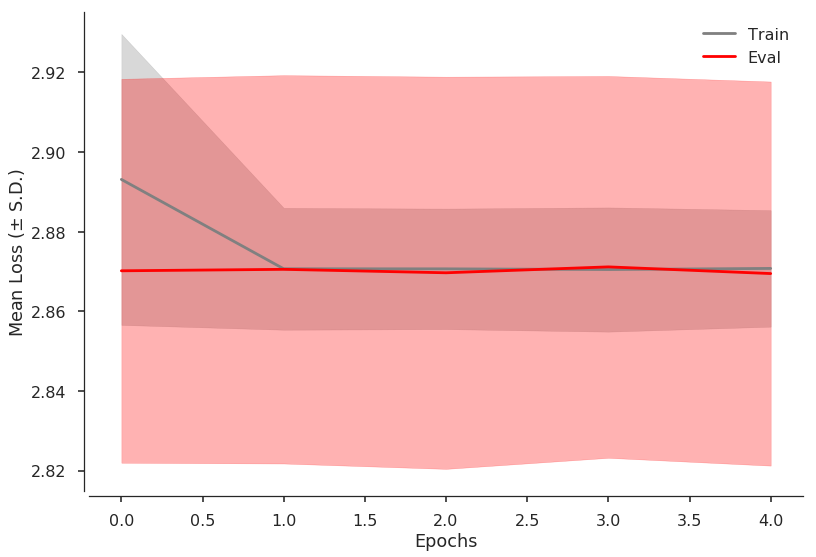

In [29]:
fig, ax = plt.subplots(1,1)
plot_losses(training_history["training_loss"],
            training_history["evaluation_loss"],
            plot_std=True,
            ax=ax)
ax.legend()
sns.despine(offset=5)

In [30]:
for title, tensors, corpus in zip(
    ["train", "dev", "test"],
    [train_tensors, dev_tensors, test_tensors],
    [train_corpus, dev_corpus, test_corpus],
                         ):
    %time predictions = model_wrapper.predict_batch(tensors)
    print_predictions(corpus, predictions, "%s.chunking.conll" % title, chunk_vocab)
    conll_eval(["conlleval", "%s.chunking.conll" % title])

CPU times: user 3min 8s, sys: 328 ms, total: 3min 8s
Wall time: 3min 4s
processed 209287 tokens with 105732 phrases; found: 8836 phrases; correct: 33.
accuracy:  29.90%; precision:   0.37%; recall:   0.03%; FB1:   0.06
             ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             ADVP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            CONJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             INTJ: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              LST: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:   0.37%; recall:   0.06%; FB1:   0.10  8836
               PP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              PRT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             SBAR: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              UCP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               VP: precision:   0.00%; recall:   0.00%; FB1:   0.00 

## CRF model

In [31]:
class BiLSTMTaggerWordCRFModel(ModelWrapper):
    def __init__(self, model,
                 loss_function,
                 use_cuda=False):
        self.model = model
        self.loss_function = None

        self.use_cuda = use_cuda
        if self.use_cuda:
            #[k.cuda() for k in self.model.modules()]
            self.model.cuda()
        
    def _process_instance_tensors(self, instance_tensors):
        X, Y, X_char = instance_tensors
        X = Variable(torch.LongTensor([X]), requires_grad=False)
        Y = torch.LongTensor(Y)
        X_char = charseq2varlist(X_char)
        if self.use_cuda:
            X = X.cuda()
            Y = Y.cuda()
            X_char = [t.cuda() for t in X_char]
        return X, X_char, Y

    def get_instance_loss(self, instance_tensors, zero_grad=True):
        if zero_grad:
            ## Clear gradients before every update else memory runs out
            self.model.zero_grad()
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        #print(X.get_device(), [t.get_device() for t in X_char])
        return self.model.loss(X, X_char, Y)
        
    def predict(self, instance_tensors):
        X, X_char, Y = self._process_instance_tensors(instance_tensors)
        emissions = self.model.forward(X, X_char)
        return self.model.crf.forward(emissions)[1]


In [32]:
use_cuda=True
n_embed=100
hidden_size=20
batch_size=10

char_emb_size=10
output_channels=50
kernel_sizes=[2, 3]

word_emb_size=100
char_embed_kwargs=dict(
    vocab_size=char_vocab.size,
    embedding_size=char_emb_size,
    out_channels=output_channels,
    kernel_sizes=kernel_sizes
)

word_char_embedding = WordCharEmbedding(
        word_vocab.size, word_emb_size,
        char_embed_kwargs, dropout=0.2)
# Assign glove embeddings
assign_embeddings(word_char_embedding.word_embeddings, pretrained_embeddings, fix_embedding=True)

model_wrapper = BiLSTMTaggerWordCRFModel(
    LSTMTaggerWordCharCRF(word_char_embedding, n_embed, hidden_size, chunk_vocab.size),
    None, use_cuda=use_cuda)

In [33]:
n_epochs=5
training_history = training_wrapper(
    model_wrapper, train_tensors, 
    eval_tensors=dev_tensors,
    optimizer=optim.Adam,
    optimizer_kwargs={
        #"lr": 0.01,
        "weight_decay": 0.5
    },
    n_epochs=n_epochs,
    batch_size=batch_size,
    use_cuda=use_cuda,
    log_file="BiLSTMTaggerWordCRFModel_CONLL2000.log"
)
model_wrapper.save("BiLSTMTaggerWordCRFModel_CONLL2000")

100%|██████████| 5/5 [47:42<00:00, 570.59s/it]

<class 'pytorch_models.LSTMTaggerWordCharCRF'> model saved to BiLSTMTaggerWordCRFModel_CONLL2000


/home/napsternxg/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


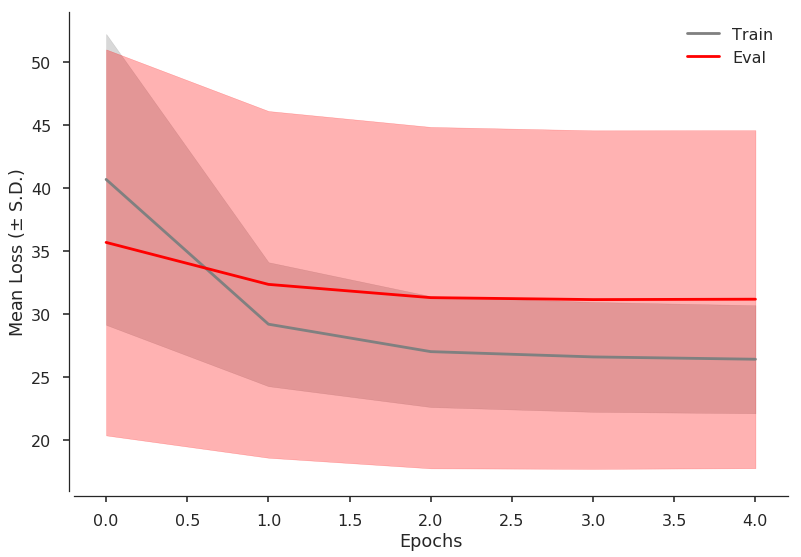

In [34]:
fig, ax = plt.subplots(1,1)
plot_losses(training_history["training_loss"],
            training_history["evaluation_loss"],
            plot_std=True,
            ax=ax)
ax.legend()
sns.despine(offset=5)

In [35]:
for title, tensors, corpus in zip(
    ["train", "dev", "test"],
    [train_tensors, dev_tensors, test_tensors],
    [train_corpus, dev_corpus, test_corpus],
                         ):
    %time predictions = model_wrapper.predict_batch(tensors)
    print_predictions(corpus, predictions, "%s.chunking.conll" % title, chunk_vocab)
    conll_eval(["conlleval", "%s.chunking.conll" % title]) 

CPU times: user 3min 13s, sys: 448 ms, total: 3min 14s
Wall time: 3min 14s
processed 209287 tokens with 105732 phrases; found: 93394 phrases; correct: 37192.
accuracy:  60.17%; precision:  39.82%; recall:  35.18%; FB1:  37.36
             ADJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             ADVP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
            CONJP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             INTJ: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              LST: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               NP: precision:  35.48%; recall:  37.10%; FB1:  36.27  56961
               PP: precision:  46.62%; recall:  80.78%; FB1:  59.12  36433
              PRT: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
             SBAR: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              UCP: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
               VP: precision:   0.00%; recall:   0.00%; 

In [36]:
temp_io = io.StringIO()
conll_eval(["conlleval", "%s.chunking.conll" % "train"], outstream=temp_io)
report = temp_io.getvalue()
print(conll_classification_report_to_df(report))
temp_io.close()

      class  accuracy  precision  recall  f1-score  support
0   overall     60.17      39.82   35.18     37.36        0
1      ADJP      0.00       0.00    0.00      0.00        0
2      ADVP      0.00       0.00    0.00      0.00        0
3     CONJP      0.00       0.00    0.00      0.00        0
4      INTJ      0.00       0.00    0.00      0.00        0
5       LST      0.00       0.00    0.00      0.00        0
6        NP      0.00      35.48   37.10     36.27    56961
7        PP      0.00      46.62   80.78     59.12    36433
8       PRT      0.00       0.00    0.00      0.00        0
9      SBAR      0.00       0.00    0.00      0.00        0
10      UCP      0.00       0.00    0.00      0.00        0
11       VP      0.00       0.00    0.00      0.00        0
